## Repeat of the book-crossing dataset recommender example that I wrote for SAS

In [1]:
import html
import numpy as np
import pandas as pd
import re
from io import StringIO
from pathlib import Path


In [3]:
import nvtabular as nvt
import merlin.io

In [4]:
data_dir = Path('/local/var/tmp/mike/bx')
ratings_file = data_dir / "BX-Book-Ratings.csv"
books_file = data_dir / "BX-Books.csv"

In [5]:
with open(books_file, 'r', encoding='iso-8859-1') as f:
    content = html.unescape(f.read())

books_df = pd.read_csv(StringIO(content),
                       header=0, 
                       sep=';', encoding='iso-8859-1',
                       names=['ISBN', 'Title', 'Author', 'Year_Of_Publication', 'Publisher'],
                       usecols=['ISBN', 'Title', 'Author', 'Year_Of_Publication', 'Publisher'],
                       dtype={'Year_Of_Publication': str})

books_df = books_df[books_df.ISBN.str.len() == 10]

books_df.head()

,ISBN,Title,Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


Display the data types:

In [6]:
books_df.dtypes

ISBN                   object
Title                  object
Author                 object
Year_Of_Publication    object
Publisher              object
dtype: object

Import the ratings data:

In [7]:
isbn_pat = re.compile('"\d+";"[0-9X]{10}";"[1-9][0]?"')
buffer = StringIO()

with open(ratings_file, 'r', encoding='iso-8859-1') as f:
    for line in f:
        if isbn_pat.match(line):
            buffer.write(line)
            
buffer.seek(0)            
ratings_df = pd.read_csv(buffer,
                         skiprows=0,
                         sep=';',
                         names=['User_ID', 'ISBN', 'Rating'],
                         dtype={'User_ID': str, 'ISBN': str, 'Rating': int})
buffer.close()

ratings_df.head()

,User_ID,ISBN,Rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276736,3257224281,8
4,276737,0600570967,6


Display the data types of the ratings data:

In [8]:
ratings_df.dtypes

User_ID    object
ISBN       object
Rating      int64
dtype: object

## Imitation data quality

* Remove duplicate ratings.
* Remove ratings for ISBNs that are not in the books DataFrame.

In [9]:
print("Ratings count before changes: ", len(ratings_df))

ratings_df.drop_duplicates(inplace=True)

ratings_df = ratings_df[ratings_df.set_index(['ISBN']).index.isin(books_df.set_index(['ISBN']).index)]

print("Ratings count after changes: ", len(ratings_df))

ratings_df.describe()


Ratings count before changes:  428204
Ratings count after changes:  383596


,Rating
count,383596.000000
mean,7.626589
std,1.841458
min,1.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,10.000000


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/local/var/tmp/mike/merlin/NVTabular/.venv/bin/python -m pip install --upgrade pip' command.
   Rating  count
0       1   1479
1       2   2374
2       3   5117
3       4   7612
4       5  45342
5       6  31671
6       7  66352
7       8  91722
8       9  60743
9      10  71184


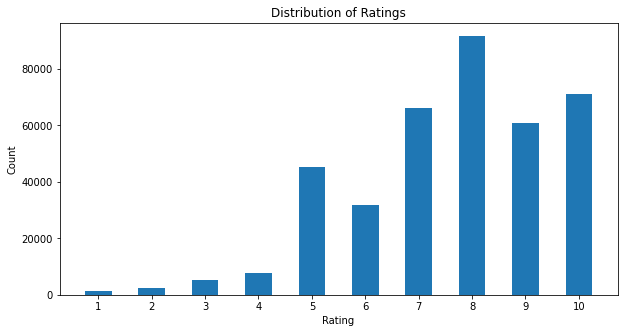

In [10]:
! pip install matplotlib
import matplotlib.pyplot as plt

x = ratings_df.groupby('Rating')['ISBN'].count().reset_index(name="count")
print(x)

# plt.hist(ratings_df.groupby("Rating").count()[['ISBN']], )
fig, ax = plt.subplots()

ax.bar(x['Rating'], x['count'], width=.5)
ax.set_title('Distribution of Ratings')
ax.set_ylabel('Count')
ax.set_xlabel('Rating')
ax.set_xticks(x['Rating'])
fig.set_size_inches(10,5)

plt.show()

## Partition the data into training and validation

After partitioning the data, save the data in Parquet format.

In [11]:
ratings = ratings_df.sample(len(ratings_df), replace=False)
validation_count = int(len(ratings) * 0.33)

train = ratings[:-validation_count]
valid = ratings[-validation_count:]

train = merlin.io.Dataset(train)
train.to_parquet(data_dir / "train.parquet")

valid = merlin.io.Dataset(valid)
valid.to_parquet(data_dir / "valid.parquet")

books = merlin.io.Dataset(books_df)
books.to_parquet(data_dir / "books.parquet")


/local/var/tmp/mike/merlin/NVTabular/.venv/lib/python3.9/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [12]:
books.head()

,ISBN,Title,Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


## Attempting to understand how to use NVT's Ops

In the discussion at <https://nvidia-merlin.github.io/NVTabular/main/examples/getting-started-movielens/02-ETL-with-NVTabular.html>,
I'm a little disoriented:

* Before the "Defining our Preprocessing Pipeline", there is a `head()` of the movies data.
That is good because it reinforces my understanding of the data.

* In the "Defining..." section, the **Example** is generic--`features = [ column_name, ... ]...`.
This is slightly disorienting and I'd like to consider if using the same variable names from the data sample could work.

* Right after the generic example, `CATEGORICAL_COLUMNS` and `LABEL_COLUMNS` are defined--and tie to the data sample, which is good, but I'm lost in what we're joining with the `JoinExternal` Op and why `joined.graph` has two tables with inputs of `userID, movieID` and outputs the same two columns.  I'm missing something.

My instinct is that the Movielens example is growing stale.  I switched to looking at <https://nvidia-merlin.github.io/Merlin/main/examples/Building-and-deploying-multi-stage-RecSys/01-Building-Recommender-Systems-with-Merlin.html> for inspiration.

In [13]:
from nvtabular.ops import (
    Categorify,
    LambdaOp,
    TagAsUserID,
    TagAsItemID,
    TagAsItemFeatures,
    TagAsUserFeatures,
    AddMetadata,
    Filter,
    Rename,
    JoinExternal,
)

from nvtabular import ColumnGroup

from merlin.schema.tags import Tags

from merlin.io.dataset import Dataset

In [14]:
display(train.head())
display(books.head())

,User_ID,ISBN,Rating
20295,11676,0425163385,8
131420,80810,0345423631,8
251047,156269,0679441883,7
48539,26535,0440235618,5
30748,14958,8420442127,7


,ISBN,Title,Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


We need a way to join the training data and the books data on the common column, ISBN.
The `JoinExternal` Op can perform the join.

(The graph that I get does not look like the graph at <https://nvidia-merlin.github.io/NVTabular/main/examples/getting-started-movielens/02-ETL-with-NVTabular.html#defining-our-preprocessing-pipeline>.
I do not know why, but my only suspicion is that the graph does not know about the `train` data.)

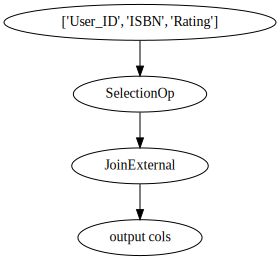

In [15]:

joined = list(train.to_ddf().columns) >> JoinExternal(books, on=["ISBN"])
joined.graph

In [16]:
wf = nvt.Workflow(joined)
wf.fit(train)
display(wf.transform(train).head())

/local/var/tmp/mike/merlin/NVTabular/.venv/lib/python3.9/site-packages/merlin/io/dataset.py:408: UserWarning: Changing an NVTabular Dataset to CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/local/var/tmp/mike/merlin/NVTabular/.venv/lib/python3.9/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,User_ID,ISBN,Rating,Title,Author,Year_Of_Publication,Publisher
0,11676,0425163385,8,The Night Crew,John Sandford,2004,Berkley Publishing Group
1,80810,0345423631,8,Night of the Wolf,Alice Borchardt,2000,Ballantine Books
2,156269,0679441883,7,Rainbow's End: A Richard Jury Novel,Martha Grimes,1995,Random House Inc
3,26535,0440235618,5,The Rogues of Regent Street: The Dangerous Gen...,JULIA LONDON,2000,Dell
4,14958,8420442127,7,La novia de Matisse,Manuel Vicent,2001,"Alfaguara Ediciones, S.A. (Spain)"


Perform some data transformation and feature engineering with the Ops available from NVTabular.


In [17]:
user_id = ["User_ID"] >> Categorify(dtype="int32") >> TagAsUserID()
item_id = ["ISBN"] >> Categorify(dtype="int32") >> TagAsItemID()

item_features = (
    ["Title", "Author", "Year_Of_Publication", "Publisher"] >> Categorify(dtype="int32") >> TagAsItemFeatures()
)

target = ColumnGroup(["Rating"]) >> LambdaOp(lambda col: (col > 7).astype("int8")) >> Rename(name="good_or_bad") >> AddMetadata(tags=[Tags.BINARY_CLASSIFICATION, "target"])


For play, view the `LambdaOp` and `Rename` Ops in action on the `Rating` column from the `train` dataset:

In [18]:
print("The data type of target: ", type(target))
workflow = nvt.Workflow(target)
workflow.fit(train)
display(workflow.transform(train).head())

The data type of target:  <class 'nvtabular.workflow.node.WorkflowNode'>


/local/var/tmp/mike/merlin/NVTabular/.venv/lib/python3.9/site-packages/merlin/io/dataset.py:252: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,good_or_bad
20295,1
131420,1
251047,0
48539,0
30748,0


Now, run the workflow on the data:

* Define an `output` variable that combines the workflow nodes.  These workflow nodes are the Ops that perform the feature engineering.
* For fun, display the workflow as a graph with graphviz.
* Define a new `workflow` variable that can perform the feature engineering.
* Fit and transform the workflow on the training data and then display the first few rows.

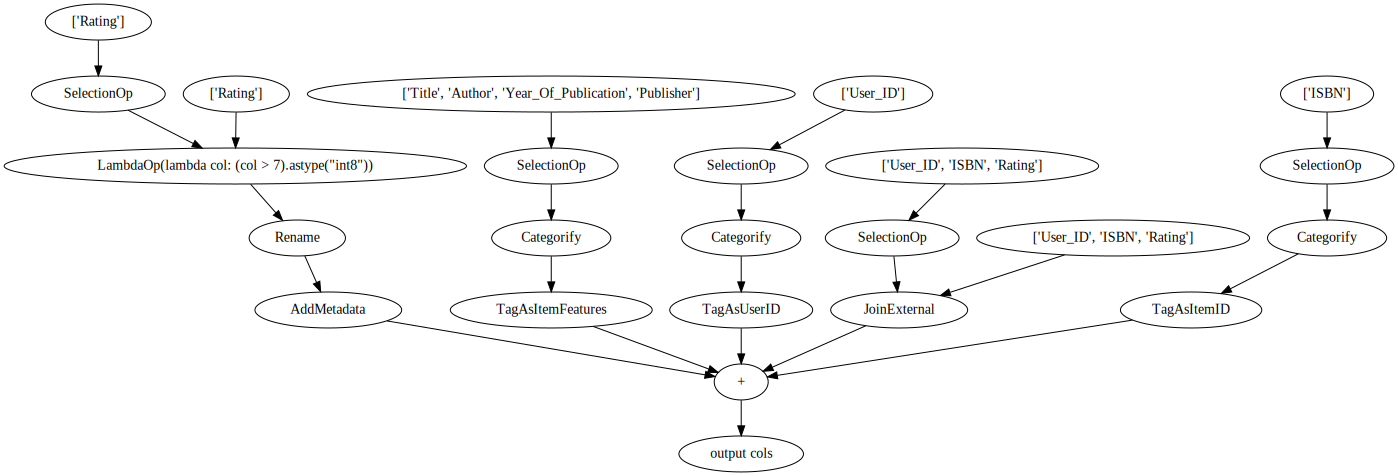

In [20]:
output = joined + user_id + item_id + item_features + target
(output).graph

In [21]:
workflow = nvt.Workflow(output)
workflow.fit(train)
#display(workflow.transform(train).head())

ValueError: Missing columns ['Title', 'Author', 'Year_Of_Publication', 'Publisher'] found in operatorSelectionOp during compute_selector.